# Imports

In [1]:
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd
import pickle as pkl
import re
from scipy.stats import spearmanr, pearsonr, rankdata

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.optim as optim

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.options.display.max_columns = 500
pd.options.mode.chained_assignment = None

from graph2net.parser import parse
from graph2net.helpers import top_n

# : Extract Micros of Given Configuration

In [2]:
def get_micros(reductions,epochs,name):
    run_stats=parse()

    matrices = {}
    for idx,row in run_stats.iterrows():
        if not type(row['cell_matrices'])==float:
            if len(row['cell_matrices'])>1:
                cell_matrix = np.array(row['cell_matrices'][0])
            else:
                cell_matrix = np.array(row['cell_matrices'])

            if matrices.get(cell_matrix.tobytes()) is None:
                matrices[cell_matrix.tobytes()] = []
            matrices[cell_matrix.tobytes()].append(row)
    matrix_dfs = [pd.DataFrame(matrices[x]) for x in matrices.keys()]

    pairs = []
    macro_cells = []
    matrix_id=0

    no_micro,no_macro = 0,0
    for matrix_df_idx,matrix_df in enumerate(matrix_dfs):
        micro_scores,macro_scores = [],[]
        micro_stats,macro_stats = [],[]
        micro,macro=False,False

        cell_counts = []
        for idx,row in matrix_df.iterrows():
            if len(row['cell_types'])==reductions and len(row['curve'])>=epochs and row['scale']==2:
                micro_scores.append(max(row['curve']))
                micro_stats.append(dict(("micro_"+k,v) for (k,v) in row.items()))
                micro=True
            elif sum(row['cell_types'])==5 and len(row['curve'])>=127:
                macro_scores.append(max(row['curve'][:128]))
                macro_stats.append(dict(("macro_"+k,v) for (k,v) in row.items()))
                macro=True
        if macro:
            macro_cells.append(macro_stats[0]['macro_cell_matrices'])
        if macro and not micro:
            no_micro +=1
        if micro and not macro:
            no_macro +=1
        if micro and macro:
            matrix_id+=1
            #micro_score = np.mean(micro_scores)
            #macro_score = np.mean(macro_scores)
            for i,micro_score in enumerate(micro_scores):
                for j,macro_score in enumerate(macro_scores):
                    pair_dict = {"_micro_score":micro_score,"_macro_score":macro_score,"matrix_id":matrix_id}
                    pair_dict.update(micro_stats[i])
                    pair_dict.update(macro_stats[j])
                    pairs.append(pair_dict)

    pkl.dump(macro_cells,open('pickle_jar/all_macro_cells.pkl','wb'))
                    
    pair_df = pd.DataFrame(pairs)
    #general
    pair_df['matrix']=pair_df['micro_cell_matrices'].apply(lambda x: x[0] if len(x)<3 else np.array(x))
    pair_df['nodes']=pair_df['matrix'].apply(lambda x: len(x[0]))
    pair_df['non_identities']=pair_df['matrix'].apply(lambda x: len(np.where(x>1)[0]))
    pair_df['operations']=pair_df['matrix'].apply(lambda x: len(np.where(np.triu(x,k=1)>0)[0]))
    pair_df['possible_ops']=pair_df['nodes'].apply(lambda x: ((x-1)*x)//2)
    pair_df['density']=pair_df['operations']/pair_df['possible_ops']
    pair_df['non_identity_density']=pair_df['non_identities']/pair_df['possible_ops']                                              
    pair_df['concats']=pair_df['matrix'].apply(lambda x: sum(np.diag(x)))

    #micro
    pair_df['micro_reductions']=pair_df['micro_cell_types'].apply(sum)
    pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: max(x)-x[0])
    pair_df['micro_first']=pair_df['micro_curve'].apply(lambda x: x[0])
    pair_df['micro_cells']=pair_df['micro_cell_types'].apply(len)
    pair_df['micro_step']=pair_df['micro_curve'].apply(lambda x: max(x)/x[0])
    pair_df['micro_efficiency']=pair_df['_micro_score']/pair_df['micro_params']

    #macro
    pair_df['macro_reductions']=pair_df['macro_cell_types'].apply(sum)
    pair_df['macro_cells']=pair_df['macro_cell_types'].apply(len)
    pair_df['macro_spacing']=(pair_df['macro_cells']-pair_df['macro_reductions'])/(pair_df['macro_reductions']-1)
    pair_df['macro_parallel']=pair_df['macro_cell_matrices'].apply(len)
    pair_df['macro_lr_max']=pair_df['macro_lr_schedule'].apply(lambda x: x['lr_max'])

    print("=== {} ===".format(name))
    print("Missing Micro_{} Runs: {}, Missing Macro Runs: {}".format(name,no_micro,no_macro))
    print("Number of Micro_{} Test Pairs: {}".format(name,len(pair_df['matrix_id'].unique())))
    print()

    pair_df=pair_df[(pair_df['macro_run_date'].apply(lambda x: '2019' in x))&(pair_df['micro_run_date'].apply(lambda x: '2019' in x if x else False))]
    pair_df=pair_df.sort_values(by='_macro_score')
    return pair_df

# : Grab Micros

In [3]:
dfs,p_dfs,d_dfs = {},{},{}

def namer(r,e):
    return "r{}_e{}".format(r,e)

for r,e in [(2,8),(2,32),(5,8)]:
    name = namer(r,e)
    dfs[name]  = get_micros(reductions=r,epochs=e, name=name)

=== r2_e8 ===
Missing Micro_r2_e8 Runs: 0, Missing Macro Runs: 598
Number of Micro_r2_e8 Test Pairs: 65

=== r2_e32 ===
Missing Micro_r2_e32 Runs: 2, Missing Macro Runs: 9
Number of Micro_r2_e32 Test Pairs: 63

=== r5_e8 ===
Missing Micro_r5_e8 Runs: 2, Missing Macro Runs: 11
Number of Micro_r5_e8 Test Pairs: 63



# : Prepare DFs for Torch

In [86]:
def process(df):
    print(len(df))
    df=df.sort_values(by='_macro_score')
    df=df[[df.columns[i] for (i,dtype) in enumerate(df.dtypes) if dtype!=object]]
    df=df[[x for x in df.columns if not any([key in x for key in ['max','epoch','early','id','max','verbose']])]]
    df=df[[x for x in df.columns if len(df[x].unique())!=1]].reset_index(drop=True)
    
    # df display
    cm = plt.cm.Greens
    s = df.style.background_gradient(cmap=cm)
    
    # plot micro/macro correlation
    plt.plot(df['_micro_score'],df['_macro_score'],".")
    plt.show()
    return df,s

def tensorify(df):
    train,test = train_test_split(df,test_size=.25)  

    train_X,train_Y = train.drop('_macro_score',1),train['_macro_score']
    test_X,test_Y = test.drop('_macro_score',1),test['_macro_score']
    print(list(train_X))
    train_Y,test_Y=train_Y.values/10000,test_Y.values/10000
    
    train_X=train_X.applymap(float)
    test_X =test_X.applymap(float)
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X,test_X=scaler.transform(train_X),scaler.transform(test_X)

    train_Y=[torch.tensor(x).float() for x in train_Y]
    train_X=[torch.tensor(x).float() for x in train_X]
    test_Y=[torch.tensor(x).float() for x in test_Y]
    test_X=[torch.tensor(x).float() for x in test_X]

    print(len(train_X),len(test_X))
    print(train_X[0].shape,train_X[0].shape)
    return train_X,train_Y,test_X,test_Y

# : Regressor Defs and Training

In [99]:
class Regressor(nn.Module):
    def __init__(self,in_dim,size):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, size)
        self.fc2 = nn.Linear(size, size)
        self.fc3 = nn.Linear(size, 1)
        
    def forward(self,x):
        x =  F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x =  self.fc3(x)
        return x#F.sigmoid(x)

def train(df):
    train_X,train_Y,test_X,test_Y = tensorify(df)
    criterion = nn.MSELoss()
    net = Regressor(train_X[0].shape[0],128)
    optimizer = optim.Adam(net.parameters())#, momentum=.9, weight_decay=3e-4)

    try:
        for epoch in range(10000):
            net.train()

            for i,val in enumerate(train_X):
                optimizer.zero_grad()
                output = net(val)
                loss = criterion(output,train_Y[i])
                loss.backward()
                optimizer.step()
            net.eval()
            losses,preds = [],[]
            for i,val in enumerate(test_X):
                output = net(val)
                loss = criterion(output,test_Y[i]).item()
                losses.append(loss)
                preds.append(int(output.item()*1e4))

            if not epoch%100:
                preds = np.array(preds)
                tests = np.array([int(x.item()*1e4) for x in test_Y])
                top_tests = top_n(test_Y) 
                top_preds = top_n(preds)

                print("\n=== EPOCH",epoch,"===")
                print("MSE:         {:.4f}".format(np.mean(losses)))
                print("C95:         {:.1f}".format(np.std(preds-tests)*1.96))
                print("Spearman:    {:.3f}".format(spearmanr(preds,test_Y)[0]))

                print("Predictions:",*["{:<4},".format(x) for x in preds[:15]])
                print("Test Values:",*["{:<4},".format(x) for x in tests[:15]])
                print("Pred Ranks: ",[top_pred[0] for top_pred in top_preds])
                print("Test Ranks: ",[top_test[0] for top_test in top_tests])

                print("Top-1 Match:",len([1 for test_val in top_tests[:1] if test_val[0] in [pred[0] for pred in top_preds[:1]]]))
                print("Top-3 Match:",len([1 for test_val in top_tests[:3] if test_val[0] in [pred[0] for pred in top_preds[:3]]]))
                print("Top-5 Match:",len([1 for test_val in top_tests[:5] if test_val[0] in [pred[0] for pred in top_preds[:5]]]))
        plt.plot(preds,test_Y,".")
    except KeyboardInterrupt:
        print("KEYBOARD INTERRUPT!")
        

# : 2 Reductions, 8 Epochs

133


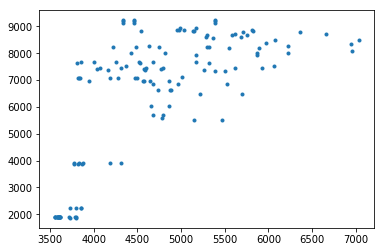

In [98]:
r,e = 2,8
name = namer(r,e)
p_dfs[name],d_dfs[name]=process(dfs[name])
display(d_dfs[name])

In [100]:
train(p_dfs[name])

['_micro_score', 'macro_params', 'macro_scale', 'micro_params', 'nodes', 'operations', 'possible_ops', 'density', 'concats', 'micro_delta', 'micro_first', 'micro_step', 'micro_efficiency', 'macro_cells', 'macro_spacing', 'macro_parallel']
99 34
torch.Size([16]) torch.Size([16])

=== EPOCH 0 ===
MSE:         0.0464
C95:         3709.9
Spearman:    0.505
Predictions: 2956, 5610, 7722, 3233, 5714, 6123, 7425, 7782, 6828, 3020, 10306, 9132, 9625, 4208, 7172,
Test Values: 1897, 2231, 5684, 1897, 2231, 1863, 6837, 7997, 7653, 1897, 5595, 8669, 6955, 3871, 8704,
Pred Ranks:  [21, 23, 17, 10, 29, 12, 19, 20, 11, 24, 26, 33, 27, 7, 2, 18, 6, 16, 14, 32, 8, 25, 5, 4, 1, 31, 28, 13, 22, 3, 9, 0, 15, 30]
Test Ranks:  [25, 18, 31, 14, 11, 23, 20, 32, 7, 26, 33, 16, 8, 17, 19, 24, 27, 12, 21, 29, 6, 2, 10, 22, 13, 28, 1, 4, 0, 3, 9, 15, 30, 5]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 0

=== EPOCH 100 ===
MSE:         0.0053
C95:         1409.6
Spearman:    0.878
Predictions: 1879, 2206, 5174, 2032

# : 2 Reductions, 32 Epochs

56


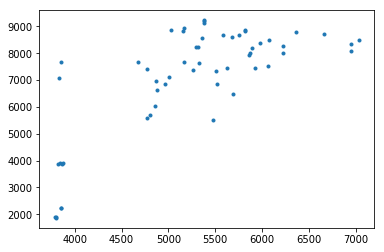

,_macro_score,_micro_score,macro_params,macro_scale,micro_params,nodes,operations,possible_ops,density,concats,micro_delta,micro_first,micro_step,micro_efficiency,macro_cells,macro_spacing,macro_parallel
0,1864,3801,1.43041e+06,6,5298,5,7,10,0.7,0,360,3441,1.10462,0.717441,13,2,1
1,1898,3785,2.10523e+06,6,5226,3,3,3,1,0,183,3602,1.05081,0.724263,21,4,2
2,1898,3797,2.10523e+06,6,5226,3,3,3,1,0,273,3524,1.07747,0.72656,21,4,2
3,2232,3851,355338,5,5226,6,7,15,0.466667,0,415,3436,1.12078,0.736892,25,5,1
4,2238,3858,1.40699e+06,6,5226,4,4,6,0.666667,0,379,3479,1.10894,0.738232,21,4,1
5,3868,3827,2.57249e+07,6,5604,3,3,3,1,1,280,3547,1.07894,0.682905,25,5,2
6,3872,3864,1.13808e+07,5,6502,4,4,6,0.666667,0,237,3627,1.06534,0.594279,25,5,1
7,3893,3838,2.23471e+07,7,5358,3,3,3,1,1,424,3414,1.12419,0.716312,21,4,1
8,3909,3873,1.67644e+07,6,5518,4,4,6,0.666667,1,548,3325,1.16481,0.701885,13,2,2
9,5515,5473,4.65063e+06,6,6242,6,6,15,0.4,1,1676,3797,1.4414,0.876802,21,4,1


In [102]:
r,e=(2,32)
name = namer(r,e)
p_dfs[name],d_dfs[name]=process(dfs[name])
display(d_dfs[name])

In [93]:
train(p_dfs[name])

['_micro_score', 'macro_params', 'macro_scale', 'micro_params', 'nodes', 'operations', 'possible_ops', 'density', 'concats', 'micro_delta', 'micro_first', 'micro_step', 'micro_efficiency', 'macro_cells', 'macro_spacing', 'macro_parallel']
42 14
torch.Size([16]) torch.Size([16])

=== EPOCH 0 ===
MSE:         0.0869
C95:         5649.8
Spearman:    -0.657
Predictions: 3978, 5706, 8052, 10283, 6976, 6306, 8559, 7721, 4862, 5762, 4967, 8629, 6654, 7774,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks:  [3, 11, 6, 2, 13, 7, 4, 12, 5, 9, 1, 10, 8, 0]
Test Ranks:  [0, 9, 4, 10, 12, 8, 2, 7, 5, 11, 1, 6, 3, 13]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 0

=== EPOCH 100 ===
MSE:         0.0250
C95:         2969.9
Spearman:    0.253
Predictions: 6606, 8216, 9814, 7817, 6814, 7293, 6004, 10381, 7953, 8092, 11431, 9081, 9949, 1699,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks


=== EPOCH 1900 ===
MSE:         0.0195
C95:         2733.7
Spearman:    0.411
Predictions: 7562, 7463, 7351, 7660, 7894, 5569, 5136, 10385, 7729, 7361, 10695, 8133, 9786, 2869,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks:  [10, 7, 12, 11, 4, 8, 3, 0, 1, 9, 2, 5, 6, 13]
Test Ranks:  [0, 9, 4, 10, 12, 8, 2, 7, 5, 11, 1, 6, 3, 13]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 3

=== EPOCH 2000 ===
MSE:         0.0194
C95:         2727.0
Spearman:    0.358
Predictions: 7495, 7413, 7354, 7824, 7918, 5491, 5040, 10355, 7690, 7348, 10529, 8121, 9751, 2580,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks:  [10, 7, 12, 11, 4, 3, 8, 0, 1, 2, 9, 5, 6, 13]
Test Ranks:  [0, 9, 4, 10, 12, 8, 2, 7, 5, 11, 1, 6, 3, 13]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 3

=== EPOCH 2100 ===
MSE:         0.0184
C95:         2660.8
Spearman:    0.393
Predictions: 7551, 7457, 7280, 7553, 7846


=== EPOCH 3800 ===
MSE:         0.0169
C95:         2547.3
Spearman:    0.547
Predictions: 7963, 7524, 7173, 7149, 7535, 6115, 4728, 10457, 7720, 7434, 10356, 8091, 9701, 2577,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks:  [7, 10, 12, 11, 0, 8, 4, 1, 9, 2, 3, 5, 6, 13]
Test Ranks:  [0, 9, 4, 10, 12, 8, 2, 7, 5, 11, 1, 6, 3, 13]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 3

=== EPOCH 3900 ===
MSE:         0.0166
C95:         2522.7
Spearman:    0.547
Predictions: 7908, 7468, 7187, 7119, 7521, 6170, 4794, 10378, 7681, 7361, 10340, 8028, 9705, 2678,
Test Values: 8931, 7450, 7997, 6464, 8551, 7631, 6628, 7993, 8212, 8833, 8485, 7508, 8269, 1897,
Pred Ranks:  [7, 10, 12, 11, 0, 8, 4, 1, 9, 2, 3, 5, 6, 13]
Test Ranks:  [0, 9, 4, 10, 12, 8, 2, 7, 5, 11, 1, 6, 3, 13]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 3

=== EPOCH 4000 ===
MSE:         0.0167
C95:         2529.6
Spearman:    0.547
Predictions: 7930, 7490, 7299, 7173, 7572

# : 5 Reductions, 8 Epochs

100


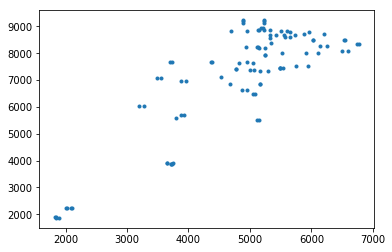

,_macro_score,_micro_score,macro_params,macro_scale,micro_params,nodes,operations,possible_ops,density,concats,micro_delta,micro_first,micro_step,micro_efficiency,macro_cells,macro_spacing,macro_parallel
0,1864,1841,1.43041e+06,6,7090,5,7,10,0.7,0,94,1747,1.05381,0.259661,13,2,1
1,1864,1891,1.43041e+06,6,7090,5,7,10,0.7,0,287,1604,1.17893,0.266714,13,2,1
2,1898,1821,2.10523e+06,6,6346,3,3,3,1,0,82,1739,1.04715,0.286952,21,4,2
3,1898,1841,2.10523e+06,6,6346,3,3,3,1,0,86,1755,1.049,0.290104,21,4,2
4,2232,2027,355338,5,6346,6,7,15,0.466667,0,63,1964,1.03208,0.319414,25,5,1
5,2232,2003,355338,5,6346,6,7,15,0.466667,0,214,1789,1.11962,0.315632,25,5,1
6,2238,2095,1.40699e+06,6,6346,4,4,6,0.666667,0,32,2063,1.01551,0.330129,21,4,1
7,2238,2101,1.40699e+06,6,6346,4,4,6,0.666667,0,76,2025,1.03753,0.331075,21,4,1
8,3868,3712,2.57249e+07,6,27612,3,3,3,1,1,325,3387,1.09596,0.134434,25,5,2
9,3868,3723,2.57249e+07,6,27612,3,3,3,1,1,487,3236,1.15049,0.134833,25,5,2


In [103]:
r,e=5,8
name = namer(r,e)
p_dfs[name],d_dfs[name]=process(dfs[name])
display(d_dfs[name])

In [104]:
train(p_dfs[name])

['_micro_score', 'macro_params', 'macro_scale', 'micro_params', 'nodes', 'operations', 'possible_ops', 'density', 'concats', 'micro_delta', 'micro_first', 'micro_step', 'micro_efficiency', 'macro_cells', 'macro_spacing', 'macro_parallel']
75 25
torch.Size([16]) torch.Size([16])

=== EPOCH 0 ===
MSE:         0.0592
C95:         4767.0
Spearman:    0.117
Predictions: 5072, 8177, 5536, 8008, 8317, 5999, 5789, 5035, 5747, 5298, 4791, 6549, 5481, 9603, 10525,
Test Values: 7682, 8269, 2238, 7354, 7993, 1863, 9114, 7653, 1897, 3908, 9226, 6955, 6028, 8507, 8343,
Pred Ranks:  [14, 13, 16, 17, 21, 4, 1, 22, 24, 3, 11, 23, 5, 6, 8, 15, 2, 12, 19, 20, 9, 0, 7, 18, 10]
Test Ranks:  [10, 6, 19, 24, 21, 16, 13, 20, 14, 1, 18, 4, 0, 7, 17, 23, 3, 11, 12, 22, 9, 2, 15, 8, 5]
Top-1 Match: 0
Top-3 Match: 0
Top-5 Match: 1

=== EPOCH 100 ===
MSE:         0.0120
C95:         1404.9
Spearman:    0.882
Predictions: 7559, 8425, 782 , 7076, 8377, 93  , 7935, 6461, 491 , 2726, 8700, 4515, 4624, 7972, 7418,
Test